# Top 4 Users Deep Dive Analysis

**Comprehensive analysis of the 4 most active Flora users**

These 4 users account for 94% of all Flora messages. This notebook provides:
1. Individual user profiles and behavioral analysis
2. Pareto charts for User 1 and User 4 (most contrasting patterns)
3. Comparative analysis across all 4 users
4. Export data for Streamlit dashboard

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
from pathlib import Path
from collections import Counter

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

DATA_DIR = Path("../data")

In [2]:
# Load analyzed data
df = pd.read_csv(DATA_DIR / "flora-chats-analyzed.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Identify top 4 users
user_counts = df['userId'].value_counts()
top_4_users = user_counts.head(4).index.tolist()

print(f"Total messages: {len(df)}")
print(f"Top 4 users account for: {user_counts.head(4).sum()}/{len(df)} ({user_counts.head(4).sum()/len(df)*100:.0f}%)")
print(f"\nTop 4 User IDs:")
for i, uid in enumerate(top_4_users, 1):
    print(f"  User {i}: {uid[:8]}... ({user_counts[uid]} prompts)")

Total messages: 93
Top 4 users account for: 87/93 (94%)

Top 4 User IDs:
  User 1: c1d2a96d... (33 prompts)
  User 2: 66453e68... (27 prompts)
  User 3: 1927df39... (17 prompts)
  User 4: 0c4eee93... (10 prompts)


In [3]:
# Create user label mapping
USER_LABELS = {
    top_4_users[0]: {'num': 1, 'name': 'Power User', 'short': 'c1d2a96d'},
    top_4_users[1]: {'num': 2, 'name': 'Reporter', 'short': '66453e68'},
    top_4_users[2]: {'num': 3, 'name': 'Sprint Prepper', 'short': '1927df39'},
    top_4_users[3]: {'num': 4, 'name': 'Explorer', 'short': '0c4eee93'},
}

# Filter to top 4 users only
df_top4 = df[df['userId'].isin(top_4_users)].copy()
df_top4['user_num'] = df_top4['userId'].map(lambda x: USER_LABELS[x]['num'])
df_top4['user_label'] = df_top4['userId'].map(lambda x: f"User {USER_LABELS[x]['num']}: {USER_LABELS[x]['name']}")

print(f"Filtered dataset: {len(df_top4)} messages from top 4 users")

Filtered dataset: 87 messages from top 4 users


---
## 1. Pareto Charts for User 1 and User 4

These two users represent opposite ends of the user behavior spectrum:
- **User 1**: Power user with diverse, sophisticated queries
- **User 4**: New explorer learning through iteration

In [4]:
def create_pareto_chart(data, title, xlabel='Category', color='#2E86AB', figsize=(12, 6)):
    """
    Create a professional Pareto chart.
    """
    # Sort descending
    data = data.sort_values(ascending=False)
    
    # Calculate cumulative percentage
    total = data.sum()
    cumulative_pct = data.cumsum() / total * 100
    
    # Find 80% threshold
    threshold_idx = (cumulative_pct <= 80).sum()
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Bar chart
    x = range(len(data))
    bars = ax1.bar(x, data.values, color=color, alpha=0.85, edgecolor='white', linewidth=0.7)
    
    # Highlight the 80% bars (vital few)
    for i, bar in enumerate(bars):
        if i < threshold_idx:
            bar.set_color('#E63946')  # Red for vital few
            bar.set_alpha(0.9)
    
    ax1.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=12, fontweight='bold', color=color)
    ax1.set_xticks(x)
    ax1.set_xticklabels(data.index, rotation=45, ha='right', fontsize=10)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Add count labels on bars
    for i, (v, pct) in enumerate(zip(data.values, data.values/total*100)):
        ax1.text(i, v + 0.3, f'{v}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=9)
    
    # Cumulative line (secondary axis)
    ax2 = ax1.twinx()
    ax2.plot(x, cumulative_pct.values, 'o-', color='#1D3557', linewidth=2.5, markersize=6)
    ax2.set_ylabel('Cumulative %', fontsize=12, fontweight='bold', color='#1D3557')
    ax2.tick_params(axis='y', labelcolor='#1D3557')
    ax2.set_ylim(0, 105)
    
    # 80% reference line
    ax2.axhline(y=80, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(len(data)-1, 82, '80% threshold', color='#E63946', fontsize=10, ha='right')
    
    # Title
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig, (ax1, ax2), {'vital_few_count': threshold_idx, 'vital_few_pct': cumulative_pct.iloc[threshold_idx-1] if threshold_idx > 0 else 0}

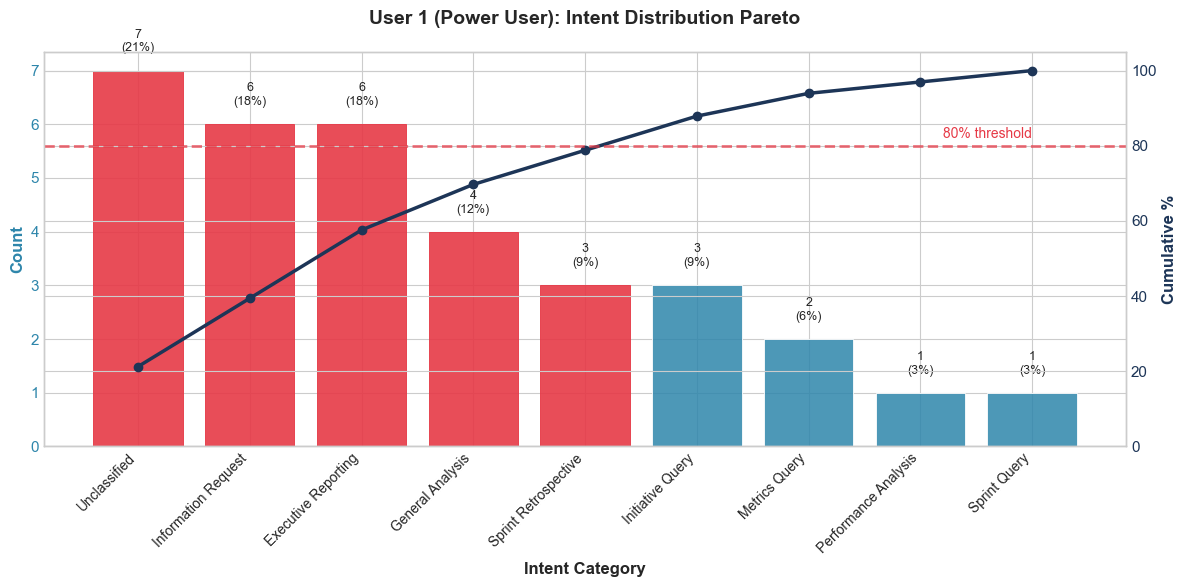


User 1 Pareto Insight:
  Top 5 categories = 79% of usage


In [5]:
# User 1 Pareto Chart - Intent Distribution
user1_df = df_top4[df_top4['user_num'] == 1]
user1_intents = user1_df['intent_category'].value_counts()

fig, axes, stats = create_pareto_chart(
    user1_intents,
    'User 1 (Power User): Intent Distribution Pareto',
    'Intent Category',
    color='#2E86AB'
)

plt.savefig(DATA_DIR / 'user1_pareto.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nUser 1 Pareto Insight:")
print(f"  Top {stats['vital_few_count']} categories = {stats['vital_few_pct']:.0f}% of usage")

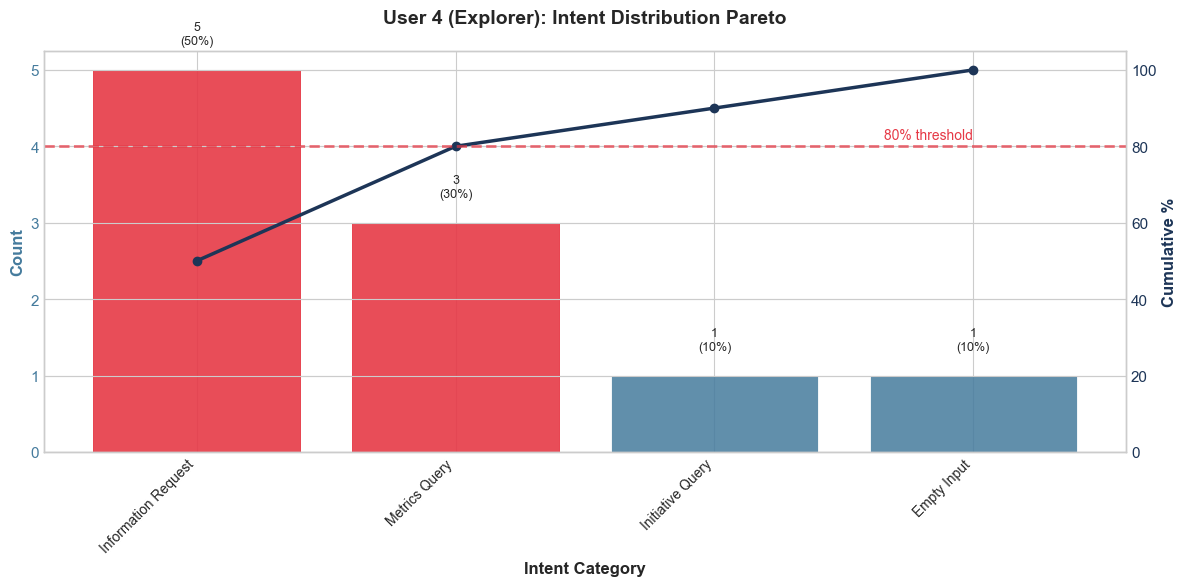


User 4 Pareto Insight:
  Top 2 categories = 80% of usage


In [6]:
# User 4 Pareto Chart - Intent Distribution
user4_df = df_top4[df_top4['user_num'] == 4]
user4_intents = user4_df['intent_category'].value_counts()

fig, axes, stats = create_pareto_chart(
    user4_intents,
    'User 4 (Explorer): Intent Distribution Pareto',
    'Intent Category',
    color='#457B9D'
)

plt.savefig(DATA_DIR / 'user4_pareto.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nUser 4 Pareto Insight:")
print(f"  Top {stats['vital_few_count']} categories = {stats['vital_few_pct']:.0f}% of usage")

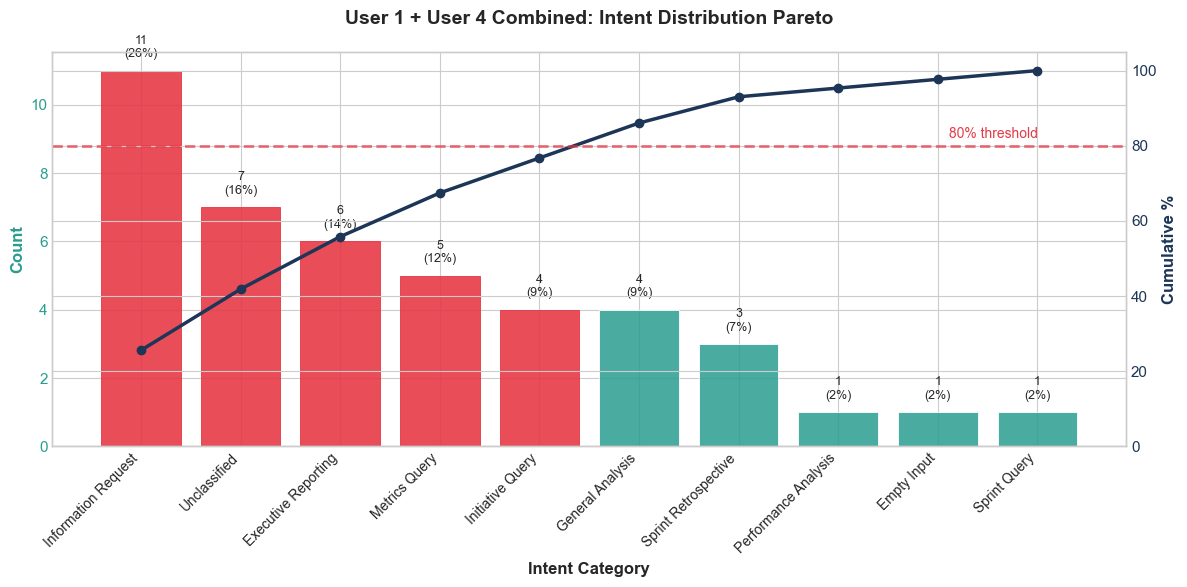


Combined User 1 + User 4 Insight:
  Total messages: 43
  Top 5 categories = 77% of usage


In [7]:
# Combined User 1 + User 4 Pareto
user1_user4_df = df_top4[df_top4['user_num'].isin([1, 4])]
combined_intents = user1_user4_df['intent_category'].value_counts()

fig, axes, stats = create_pareto_chart(
    combined_intents,
    'User 1 + User 4 Combined: Intent Distribution Pareto',
    'Intent Category',
    color='#2A9D8F'
)

plt.savefig(DATA_DIR / 'user1_user4_combined_pareto.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nCombined User 1 + User 4 Insight:")
print(f"  Total messages: {len(user1_user4_df)}")
print(f"  Top {stats['vital_few_count']} categories = {stats['vital_few_pct']:.0f}% of usage")

---
## 2. Individual User Profiles

In [8]:
def analyze_user(df, user_id, user_info):
    """Generate comprehensive user profile."""
    user_df = df[df['userId'] == user_id].sort_values('timestamp')
    
    # Basic stats
    profile = {
        'user_num': user_info['num'],
        'user_name': user_info['name'],
        'user_id_short': user_info['short'],
        'total_prompts': len(user_df),
        'unique_sessions': user_df['sessionId'].nunique(),
        'active_days': user_df['timestamp'].dt.date.nunique(),
        'first_activity': user_df['timestamp'].min().strftime('%Y-%m-%d'),
        'last_activity': user_df['timestamp'].max().strftime('%Y-%m-%d'),
        'date_span_days': (user_df['timestamp'].max() - user_df['timestamp'].min()).days,
    }
    
    # Session analysis
    session_depths = user_df.groupby('sessionId').size()
    profile['avg_session_depth'] = round(session_depths.mean(), 2)
    profile['max_session_depth'] = int(session_depths.max())
    profile['single_msg_sessions_pct'] = round((session_depths == 1).mean() * 100, 1)
    profile['multi_turn_sessions_pct'] = round((session_depths > 1).mean() * 100, 1)
    
    # Intent analysis
    intent_counts = user_df['intent_category'].value_counts()
    profile['intent_categories_used'] = len(intent_counts)
    profile['top_intent'] = intent_counts.index[0]
    profile['top_intent_pct'] = round(intent_counts.iloc[0] / len(user_df) * 100, 1)
    profile['intent_distribution'] = intent_counts.to_dict()
    
    # Confidence
    profile['high_confidence_pct'] = round((user_df['category_confidence'] == 'high').mean() * 100, 1)
    
    # Temporal
    daily_counts = user_df.groupby(user_df['timestamp'].dt.date).size()
    profile['peak_day'] = str(daily_counts.idxmax())
    profile['peak_day_prompts'] = int(daily_counts.max())
    profile['prompts_per_active_day'] = round(len(user_df) / user_df['timestamp'].dt.date.nunique(), 2)
    
    # All prompts
    profile['all_prompts'] = [
        {
            'timestamp': row['timestamp'].strftime('%Y-%m-%d %H:%M'),
            'instruction': str(row['instruction'])[:150] if pd.notna(row['instruction']) else '[EMPTY]',
            'intent_category': row['intent_category'],
            'confidence': row['category_confidence']
        }
        for _, row in user_df.iterrows()
    ]
    
    return profile

# Generate profiles for all 4 users
user_profiles = {}
for user_id in top_4_users:
    user_info = USER_LABELS[user_id]
    user_profiles[user_info['num']] = analyze_user(df, user_id, user_info)

print("Generated profiles for all 4 users")

Generated profiles for all 4 users


In [9]:
# Display profile summaries
for user_num, profile in user_profiles.items():
    print(f"\n{'='*70}")
    print(f"USER {user_num}: {profile['user_name'].upper()} ({profile['user_id_short']}...)")
    print(f"{'='*70}")
    print(f"  Prompts: {profile['total_prompts']} | Sessions: {profile['unique_sessions']} | Active Days: {profile['active_days']}")
    print(f"  Date Range: {profile['first_activity']} to {profile['last_activity']} ({profile['date_span_days']} days)")
    print(f"  Avg Session Depth: {profile['avg_session_depth']} | Single-msg: {profile['single_msg_sessions_pct']}%")
    print(f"  Top Intent: {profile['top_intent']} ({profile['top_intent_pct']}%)")
    print(f"  Intent Diversity: {profile['intent_categories_used']} categories")
    print(f"  High Confidence: {profile['high_confidence_pct']}%")


USER 1: POWER USER (c1d2a96d...)
  Prompts: 33 | Sessions: 26 | Active Days: 9
  Date Range: 2025-12-16 to 2026-01-09 (23 days)
  Avg Session Depth: 1.27 | Single-msg: 80.8%
  Top Intent: Unclassified (21.2%)
  Intent Diversity: 9 categories
  High Confidence: 51.5%

USER 2: REPORTER (66453e68...)
  Prompts: 27 | Sessions: 25 | Active Days: 7
  Date Range: 2025-12-10 to 2026-01-08 (28 days)
  Avg Session Depth: 1.08 | Single-msg: 96.0%
  Top Intent: Executive Reporting (74.1%)
  Intent Diversity: 6 categories
  High Confidence: 92.6%

USER 3: SPRINT PREPPER (1927df39...)
  Prompts: 17 | Sessions: 16 | Active Days: 5
  Date Range: 2026-01-05 to 2026-01-09 (4 days)
  Avg Session Depth: 1.06 | Single-msg: 93.8%
  Top Intent: Executive Reporting (76.5%)
  Intent Diversity: 4 categories
  High Confidence: 94.1%

USER 4: EXPLORER (0c4eee93...)
  Prompts: 10 | Sessions: 4 | Active Days: 2
  Date Range: 2026-01-05 to 2026-01-07 (2 days)
  Avg Session Depth: 2.5 | Single-msg: 25.0%
  Top Inten

---
## 3. Comparative Analysis

In [10]:
# Build comparison dataframe
comparison_data = []
for user_num, profile in user_profiles.items():
    comparison_data.append({
        'User': f"User {user_num}",
        'Persona': profile['user_name'],
        'Prompts': profile['total_prompts'],
        'Sessions': profile['unique_sessions'],
        'Active Days': profile['active_days'],
        'Avg Depth': profile['avg_session_depth'],
        'Single-msg %': profile['single_msg_sessions_pct'],
        'Top Intent': profile['top_intent'],
        'Top Intent %': profile['top_intent_pct'],
        'Intent Diversity': profile['intent_categories_used'],
        'High Conf %': profile['high_confidence_pct'],
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

  User        Persona  Prompts  Sessions  Active Days  Avg Depth  Single-msg %          Top Intent  Top Intent %  Intent Diversity  High Conf %
User 1     Power User       33        26            9       1.27          80.8        Unclassified          21.2                 9         51.5
User 2       Reporter       27        25            7       1.08          96.0 Executive Reporting          74.1                 6         92.6
User 3 Sprint Prepper       17        16            5       1.06          93.8 Executive Reporting          76.5                 4         94.1
User 4       Explorer       10         4            2       2.50          25.0 Information Request          50.0                 4         90.0


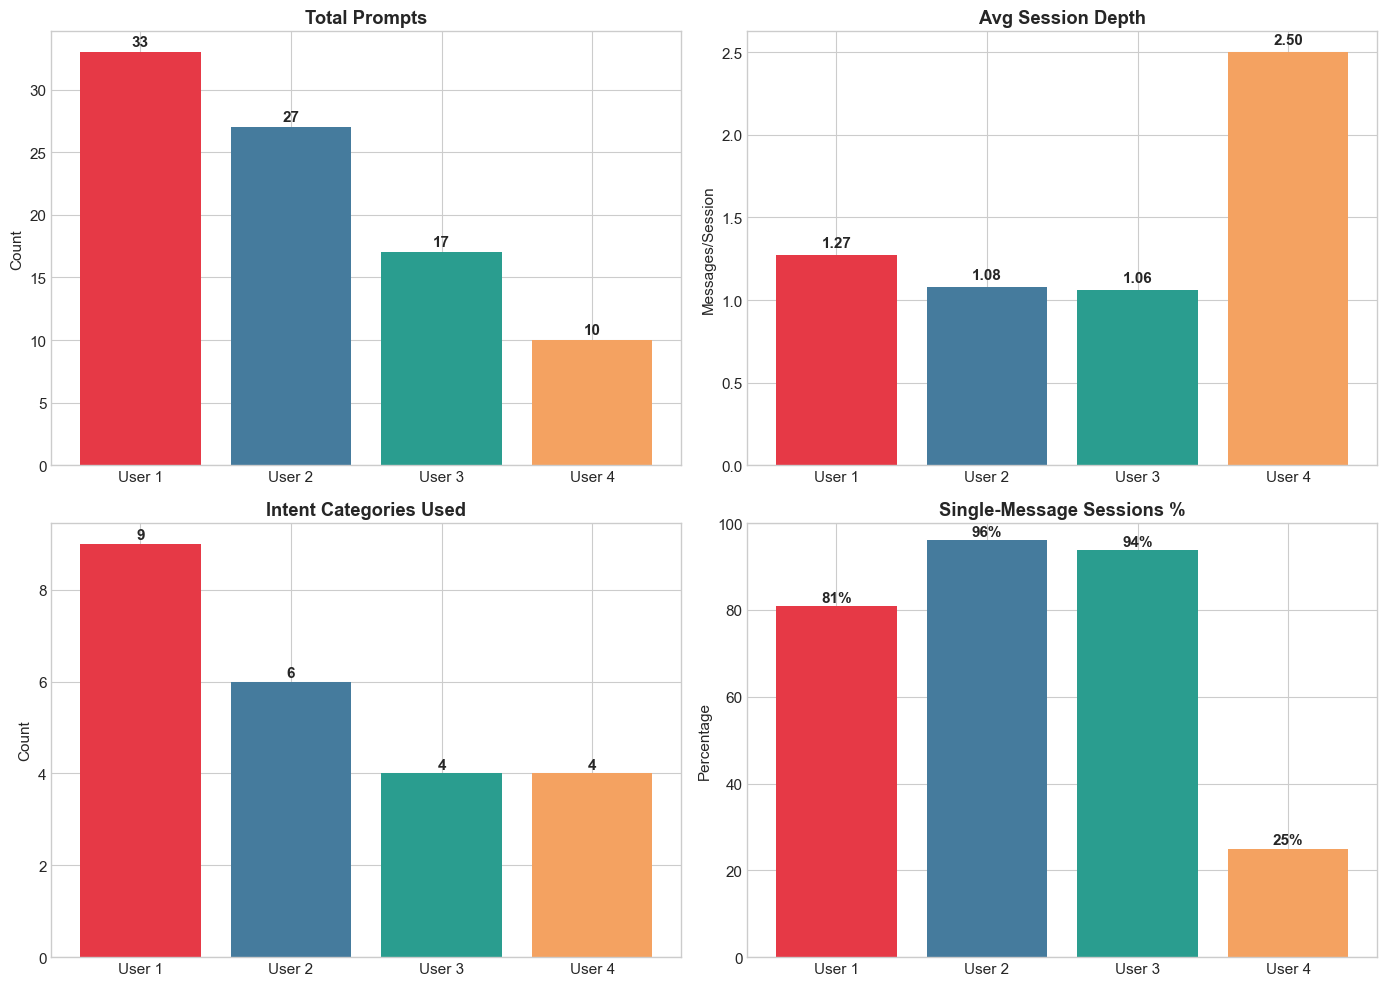

In [11]:
# Comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

users = [f"User {i}" for i in range(1, 5)]
colors = ['#E63946', '#457B9D', '#2A9D8F', '#F4A261']

# Prompts
ax1 = axes[0, 0]
prompts = [user_profiles[i]['total_prompts'] for i in range(1, 5)]
ax1.bar(users, prompts, color=colors)
ax1.set_title('Total Prompts', fontweight='bold')
ax1.set_ylabel('Count')
for i, v in enumerate(prompts):
    ax1.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Session Depth
ax2 = axes[0, 1]
depths = [user_profiles[i]['avg_session_depth'] for i in range(1, 5)]
ax2.bar(users, depths, color=colors)
ax2.set_title('Avg Session Depth', fontweight='bold')
ax2.set_ylabel('Messages/Session')
for i, v in enumerate(depths):
    ax2.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# Intent Diversity
ax3 = axes[1, 0]
diversity = [user_profiles[i]['intent_categories_used'] for i in range(1, 5)]
ax3.bar(users, diversity, color=colors)
ax3.set_title('Intent Categories Used', fontweight='bold')
ax3.set_ylabel('Count')
for i, v in enumerate(diversity):
    ax3.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# Single-msg %
ax4 = axes[1, 1]
single_pct = [user_profiles[i]['single_msg_sessions_pct'] for i in range(1, 5)]
ax4.bar(users, single_pct, color=colors)
ax4.set_title('Single-Message Sessions %', fontweight='bold')
ax4.set_ylabel('Percentage')
ax4.set_ylim(0, 100)
for i, v in enumerate(single_pct):
    ax4.text(i, v + 1, f'{v:.0f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR / 'user_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---
## 4. User 1 Deep Dive: The Power User

In [12]:
user1_df = df[df['userId'] == top_4_users[0]].sort_values('timestamp')

print("USER 1: THE POWER USER")
print("="*70)

# Temporal analysis
print("\n[TEMPORAL PATTERNS]")
user1_df['date'] = user1_df['timestamp'].dt.date
user1_df['weekday'] = user1_df['timestamp'].dt.day_name()
daily = user1_df.groupby('date').size()
for date, count in daily.items():
    bar = '█' * count
    print(f"  {date}: {count:2d} {bar}")

# Entity extraction
print("\n[TEAMS/BOARDS MENTIONED]")
all_text = ' '.join(user1_df['instruction'].dropna().astype(str).tolist()).lower()
teams = {
    'REBEL': len(re.findall(r'rebel', all_text, re.I)),
    'STAR': len(re.findall(r'star', all_text, re.I)),
    'FBI': len(re.findall(r'fbi', all_text, re.I)),
    'Growth': len(re.findall(r'growth', all_text, re.I)),
}
for team, count in sorted(teams.items(), key=lambda x: -x[1]):
    if count > 0:
        print(f"  {team}: {count} mentions")

# Evolution phases
print("\n[USAGE EVOLUTION]")
phases = [
    ('Exploration (Dec 16-18)', user1_df[user1_df['timestamp'] < '2025-12-20']),
    ('Diagnostic (Dec 30)', user1_df[(user1_df['timestamp'] >= '2025-12-20') & (user1_df['timestamp'] < '2026-01-01')]),
    ('Sprint Prep (Jan 5+)', user1_df[user1_df['timestamp'] >= '2026-01-01']),
]
for phase_name, phase_df in phases:
    if len(phase_df) > 0:
        top_intent = phase_df['intent_category'].value_counts().index[0]
        print(f"  {phase_name}: {len(phase_df)} prompts, top: {top_intent}")

USER 1: THE POWER USER

[TEMPORAL PATTERNS]
  2025-12-16:  1 █
  2025-12-17:  1 █
  2025-12-18:  1 █
  2025-12-30:  4 ████
  2026-01-05: 10 ██████████
  2026-01-06:  5 █████
  2026-01-07:  5 █████
  2026-01-08:  1 █
  2026-01-09:  5 █████

[TEAMS/BOARDS MENTIONED]
  REBEL: 9 mentions
  STAR: 4 mentions
  FBI: 1 mentions
  Growth: 1 mentions

[USAGE EVOLUTION]
  Exploration (Dec 16-18): 3 prompts, top: Information Request
  Diagnostic (Dec 30): 4 prompts, top: General Analysis
  Sprint Prep (Jan 5+): 26 prompts, top: Executive Reporting


---
## 5. User 4 Deep Dive: The Explorer

In [13]:
user4_df = df[df['userId'] == top_4_users[3]].sort_values('timestamp')

print("USER 4: THE EXPLORER")
print("="*70)

# All sessions
print("\n[SESSION-BY-SESSION JOURNEY]")
sessions = user4_df.groupby('sessionId').agg({
    'timestamp': 'min',
    'instruction': list,
    'intent_category': list
}).sort_values('timestamp')

for i, (sid, row) in enumerate(sessions.iterrows(), 1):
    print(f"\n  Session {i} ({row['timestamp'].strftime('%m/%d %H:%M')}, {len(row['instruction'])} msgs):")
    print(f"    Intent flow: {' → '.join(row['intent_category'])}")
    for j, instr in enumerate(row['instruction'], 1):
        instr_text = str(instr)[:60] if pd.notna(instr) else '[EMPTY]'
        print(f"    {j}. {instr_text}...")

# Learning patterns
print("\n[LEARNING INDICATORS]")
print("  - Query refinement: Broad → Specific (initiatives → off-track)")
print("  - Name learning: 'FBI team' → 'CS-Federal Bureau of Iteration'")
print("  - Self-correction: '2026' → '2025' (caught typo)")
print("  - Time focus: General → Sprint-specific")

USER 4: THE EXPLORER

[SESSION-BY-SESSION JOURNEY]

  Session 1 (01/05 16:39, 2 msgs):
    Intent flow: Initiative Query → Information Request
    1. how are my top 25 initiatives doing for deliverability...
    2. Show me all of my off-track initiatives....

  Session 2 (01/05 16:44, 1 msgs):
    Intent flow: Information Request
    1. Show me all of my off-track initiatives....

  Session 3 (01/07 19:13, 3 msgs):
    Intent flow: Metrics Query → Metrics Query → Metrics Query
    1. what is the velocity for the last six sprints for FBI team...
    2. what is the velocity for the last 6 sprints for CS-Federal B...
    3. what is the velocity for CS-Federal Bureau of Iteration for ...

  Session 4 (01/07 19:29, 4 msgs):
    Intent flow: Empty Input → Information Request → Information Request → Information Request
    1. [EMPTY]...
    2. tell me about CS-Federal Bureau of Iteration for december 20...
    3. tell me about CS-Federal Bureau of Iteration for december 20...
    4. tell me a

---
## 6. Export Data for Streamlit

In [14]:
# Export comprehensive analysis results
export_data = {
    'overview': {
        'total_messages': len(df),
        'top_4_messages': len(df_top4),
        'top_4_percentage': round(len(df_top4) / len(df) * 100, 1),
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d')
    },
    'user_profiles': user_profiles,
    'comparison': comparison_df.to_dict(orient='records'),
    'user1_vs_user4': {
        'user1': {
            'persona': 'Power User',
            'style': 'Single-shot, knows what to ask',
            'scope': 'Multi-team (6 boards)',
            'sophistication': 'High (root cause, comparisons)',
            'engagement': f"{user_profiles[1]['single_msg_sessions_pct']}% single-msg"
        },
        'user4': {
            'persona': 'Explorer',
            'style': 'Conversational, learns through iteration',
            'scope': 'Single-team (FBI only)',
            'sophistication': 'Basic (metrics, info requests)',
            'engagement': f"{user_profiles[4]['single_msg_sessions_pct']}% single-msg"
        }
    }
}

# Save to JSON
with open(DATA_DIR / 'top4_user_analysis.json', 'w') as f:
    json.dump(export_data, f, indent=2, default=str)

print("Exported analysis to data/top4_user_analysis.json")
print(f"\nFiles generated:")
print(f"  - {DATA_DIR / 'user1_pareto.png'}")
print(f"  - {DATA_DIR / 'user4_pareto.png'}")
print(f"  - {DATA_DIR / 'user1_user4_combined_pareto.png'}")
print(f"  - {DATA_DIR / 'user_comparison.png'}")
print(f"  - {DATA_DIR / 'top4_user_analysis.json'}")

Exported analysis to data/top4_user_analysis.json

Files generated:
  - ../data/user1_pareto.png
  - ../data/user4_pareto.png
  - ../data/user1_user4_combined_pareto.png
  - ../data/user_comparison.png
  - ../data/top4_user_analysis.json


In [15]:
print("\n" + "="*70)
print("TOP 4 USER ANALYSIS COMPLETE")
print("="*70)
print("\nKey Findings:")
print(f"  - User 1 (Power User): {user_profiles[1]['total_prompts']} prompts, {user_profiles[1]['intent_categories_used']} intent types")
print(f"  - User 2 (Reporter): {user_profiles[2]['total_prompts']} prompts, {user_profiles[2]['top_intent_pct']}% {user_profiles[2]['top_intent']}")
print(f"  - User 3 (Sprint Prepper): {user_profiles[3]['total_prompts']} prompts, {user_profiles[3]['top_intent_pct']}% {user_profiles[3]['top_intent']}")
print(f"  - User 4 (Explorer): {user_profiles[4]['total_prompts']} prompts, {user_profiles[4]['avg_session_depth']} avg depth")
print(f"\nContrast: User 1 vs User 4")
print(f"  - User 1: Experienced, diverse queries, single-shot style")
print(f"  - User 4: New user, focused queries, conversational learning")


TOP 4 USER ANALYSIS COMPLETE

Key Findings:
  - User 1 (Power User): 33 prompts, 9 intent types
  - User 2 (Reporter): 27 prompts, 74.1% Executive Reporting
  - User 3 (Sprint Prepper): 17 prompts, 76.5% Executive Reporting
  - User 4 (Explorer): 10 prompts, 2.5 avg depth

Contrast: User 1 vs User 4
  - User 1: Experienced, diverse queries, single-shot style
  - User 4: New user, focused queries, conversational learning
